# Goals


# Imports

In [37]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import (confusion_matrix, classification_report, f1_score,
                             accuracy_score, recall_score, roc_auc_score,
                             roc_curve, precision_score)

pd.options.display.max_columns=100

def plot_roc_curve(fpr, tpr, y_true, y_score):
    plt.title('Receiver Operating Characteristic: {:.3}'.format(roc_auc_score(y_true, y_score)))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7")
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Data load

In [2]:
bogodis = pd.read_csv('bogodis.csv')
print(bogodis.shape)
print(bogodis.offer_successful.value_counts())
bogodis.head()

(61042, 26)
0    36834
1    24208
Name: offer_successful, dtype: int64


,person,offer_id,received_id,offer_successful,sum_event_offer_received,sum_event_offer_viewed,sum_event_transaction,sum_event_offer_completed,sum_amount,mean_difficulty,mean_amount,count_received_id,channel_email,channel_mobile,channel_social,channel_web,age,income,gender_F,gender_M,gender_O,gender_Unknown,year,month,day,week
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,0,3,2,7,3,105.44,8.125,7.029333,3.0,1.0,1.0,0.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,3.0,0,3,2,7,3,105.44,8.125,7.029333,3.0,1.0,1.0,1.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4.0,1,3,2,7,3,105.44,8.125,7.029333,3.0,1.0,1.0,1.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,2,2,3,0,4.09,5.000,0.584286,2.0,1.0,1.0,1.0,1.0,118,0.0,0,0,0,1,2018,4,25,17
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0,2,2,3,0,4.09,5.000,0.584286,2.0,1.0,1.0,1.0,1.0,118,0.0,0,0,0,1,2018,4,25,17


In [3]:
informational = pd.read_csv('informational.csv')
print(informational.shape)
print(informational.offer_successful.value_counts())
informational.head()

(15235, 26)
0.0    9473
1.0    5762
Name: offer_successful, dtype: int64


,person,offer_id,received_id,offer_successful,sum_event_offer_received,sum_event_offer_viewed,sum_event_transaction,sum_event_offer_completed,sum_amount,mean_difficulty,mean_amount,count_received_id,channel_email,channel_mobile,channel_social,channel_web,age,income,gender_F,gender_M,gender_O,gender_Unknown,year,month,day,week
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,0.0,2,2,1,0,22.16,0.0,4.432,2.0,1.0,1.0,0.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,2.0,1.0,2,2,1,0,22.16,0.0,4.432,2.0,1.0,1.0,1.0,0.0,33,72000.0,0,1,0,0,2017,4,21,16
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,9.0,0.0,2,2,1,0,13.49,0.0,2.698,2.0,1.0,1.0,0.0,1.0,40,57000.0,0,0,1,0,2018,1,9,2
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,10.0,0.0,2,2,1,0,13.49,0.0,2.698,2.0,1.0,1.0,1.0,0.0,40,57000.0,0,0,1,0,2018,1,9,2
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,13.0,0.0,1,1,3,0,64.67,0.0,12.934,1.0,1.0,1.0,1.0,0.0,59,90000.0,1,0,0,0,2016,3,4,9


# 1ST MODELING TASK: BOGO and discount offers

## partition

In [5]:
X = bogodis.drop(['person', 'offer_id', 'received_id', 'offer_successful'], axis=1)
y = bogodis['offer_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((42729, 22), (18313, 22))

## Test out-of-the-box models

In [6]:
seed = 42

clfs = [SVC(random_state=seed),
        LogisticRegression(random_state=seed),
        DummyClassifier(strategy='most_frequent', random_state=seed),
        RandomForestClassifier(random_state=seed),
        XGBClassifier(random_state=seed)]

f1_dict = dict()
accuracy_dict = dict()

for clf in clfs:
    name = clf.__class__.__name__
    print(name)

SVC
LogisticRegression
DummyClassifier
RandomForestClassifier
XGBClassifier


In [8]:
seed = 42

clfs = [SVC(random_state=seed),
        LogisticRegression(random_state=seed),
        DummyClassifier(strategy='most_frequent', random_state=seed),
        RandomForestClassifier(random_state=seed),
        XGBClassifier(random_state=seed)]

f1_dict = dict()
accuracy_dict = dict()

for clf in clfs:
    name = clf.__class__.__name__
    
    if name in ['SVC', 'LogisticRegression']:
        scaler = QuantileTransformer()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    
    # record results
    f1_dict[name] = f1_score(y_test, y_pred)
    accuracy_dict[name] = accuracy_score(y_test, y_pred)

/Users/gabrielestivalet/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gabrielestivalet/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [9]:
f1_dict

{'SVC': 0.7750940814231955,
 'LogisticRegression': 0.7592707258341933,
 'DummyClassifier': 0.0,
 'RandomForestClassifier': 0.6873859969131472,
 'XGBClassifier': 0.7815966041352869}

In [10]:
accuracy_dict

{'SVC': 0.8205100202042265,
 'LogisticRegression': 0.8089335444766014,
 'DummyClassifier': 0.6033964942936711,
 'RandomForestClassifier': 0.7566755856495386,
 'XGBClassifier': 0.8258068039097909}

## Optimize best model

In [14]:
xgb = XGBClassifier(objective='binary:logistic',
                    booster='gbtree')

parameters = {'max_depth':[3,5,7,10],
             'learning_rate':[0.001,0.01,0.1,1,10],
             'n_estimators':[50,100,300,500],
             'gamma':[0.01,1,10],
             'reg_alpha':[0.01,1,10],
             'colsample_bytree':[0.3, 0.5]}

search = RandomizedSearchCV(xgb, param_distributions=parameters,
                            n_iter=50,
                            n_jobs=-1,
                            cv=5,
                            random_state=seed,
                            verbose=1)

search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 12.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'max_depth': [3, 5, 7, 10], 'learning_rate': [0.001, 0.01, 0.1, 1, 10], 'n_estimators': [50, 100, 300, 500], 'gamma': [0.01, 1, 10], 'reg_alpha': [0.01, 1, 10], 'colsample_bytree': [0.3, 0.5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [25]:
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.86      0.86     11050
          1       0.78      0.79      0.79      7263

avg / total       0.83      0.83      0.83     18313



In [26]:
confusion_matrix(y_test, y_pred)

array([[9486, 1564],
       [1556, 5707]])

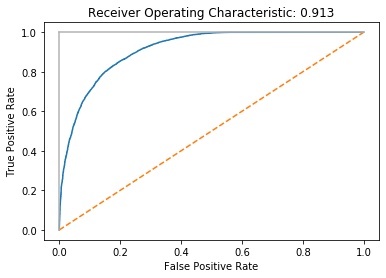

In [33]:
y_pred_proba = search.best_estimator_.predict_proba(X_test)[:,1]

# Create true and false positive rates
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
plot_roc_curve(fpr, tpr, y_test, y_pred_proba)

In [44]:
# Saving the model
filename = 'bogo_discount_model.sav'
pickle.dump(search.best_estimator_, open(filename, 'wb'))

# Loading the model
search = pickle.load(open(filename,'rb'))
search

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=nan, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
#from tpot import TPOTClassifier

#tpot = TPOTClassifier(generations=5, verbosity=2, n_jobs=-1)
#tpot.fit(X_train, y_train)

In [36]:
#tpot.score(X_test, y_test)

# 2ND MODELING TASK: informational offers

## partition

In [16]:
X2 = informational.drop(['person', 'offer_id', 'received_id', 'offer_successful'], axis=1)
y2 = informational['offer_successful']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, test_size=0.3, random_state=42)
X_train2.shape, X_test2.shape

((10664, 22), (4571, 22))

## Test out-of-the-box models

In [17]:
seed = 42

clfs = [SVC(random_state=seed),
        LogisticRegression(random_state=seed),
        DummyClassifier(strategy='most_frequent', random_state=seed),
        RandomForestClassifier(random_state=seed),
        XGBClassifier(random_state=seed)]

f1_dict2 = dict()
accuracy_dict2 = dict()

for clf in clfs:
    name = clf.__class__.__name__
    
    if name in ['SVC', 'LogisticRegression']:
        scaler = QuantileTransformer()
        scaler.fit(X_train2)
        X_train_scaled2 = scaler.transform(X_train2)
        X_test_scaled2  = scaler.transform(X_test2)
        clf.fit(X_train_scaled2, y_train2)
        y_pred2 = clf.predict(X_test_scaled2)
    else:
        clf.fit(X_train2, y_train2)
        y_pred2 = clf.predict(X_test2)
    
    # record results
    f1_dict2[name] = f1_score(y_test2, y_pred2)
    accuracy_dict2[name] = accuracy_score(y_test2, y_pred2)

In [18]:
f1_dict2

{'SVC': 0.7467720685111989,
 'LogisticRegression': 0.7007760850819201,
 'DummyClassifier': 0.0,
 'RandomForestClassifier': 0.6668594563331406,
 'XGBClassifier': 0.7398749660233759}

In [19]:
accuracy_dict2

{'SVC': 0.7897615401443885,
 'LogisticRegression': 0.7722598993655655,
 'DummyClassifier': 0.6217457886676876,
 'RandomForestClassifier': 0.7479763727849486,
 'XGBClassifier': 0.7906366221833296}

## Optimize best model

In [20]:
xgb = XGBClassifier(objective='binary:logistic',
                    booster='gbtree')

parameters = {'max_depth':[3,5,7,10],
             'learning_rate':[0.001,0.01,0.1,1,10],
             'n_estimators':[50,100,300,500],
             'gamma':[0.01,1,10],
             'reg_alpha':[0.01,1,10],
             'colsample_bytree':[0.3, 0.5]}

search2 = RandomizedSearchCV(xgb, param_distributions=parameters,
                            n_iter=50,
                            n_jobs=-1,
                            cv=5,
                            random_state=seed,
                            verbose=1)

search2.fit(X_train2, y_train2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'max_depth': [3, 5, 7, 10], 'learning_rate': [0.001, 0.01, 0.1, 1, 10], 'n_estimators': [50, 100, 300, 500], 'gamma': [0.01, 1, 10], 'reg_alpha': [0.01, 1, 10], 'colsample_bytree': [0.3, 0.5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [22]:
y_pred2 = search2.predict(X_test2)
print(classification_report(y_test2, y_pred2))

             precision    recall  f1-score   support

        0.0       0.86      0.79      0.83      2842
        1.0       0.70      0.79      0.74      1729

avg / total       0.80      0.79      0.80      4571



In [24]:
confusion_matrix(y_test2, y_pred2)

array([[2252,  590],
       [ 356, 1373]])

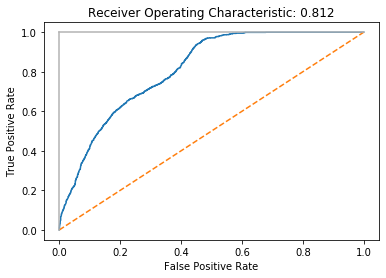

In [34]:
y_pred_proba2 = search.best_estimator_.predict_proba(X_test2)[:,1]

# Create true and false positive rates
fpr2, tpr2, threshold = roc_curve(y_test2, y_pred_proba2)
plot_roc_curve(fpr2, tpr2, y_test2, y_pred_proba2)

In [42]:
# Saving the model
filename = 'informational_model.sav'
pickle.dump(search2.best_estimator_, open(filename, 'wb'))

# Loading the model
search2 = pickle.load(open(filename,'rb'))
search2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=nan, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)